<a href="https://colab.research.google.com/github/Ankita-chouhan-github/Book-Recommendation-System/blob/main/Unsupervised_ML_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unsupervised ML Capstone Project: Book Recommemdation System**

The objective of a book recommendation system is to predict buyer’s interest and recommend books to them respectively. That system can take into regard many parameters like book content and quality by filtering user reviews.

In [3]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [5]:
books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Books.csv',encoding="latin-1")
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Ratings.csv',encoding="latin-1")
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised ML Capstone Project/Users.csv',encoding="latin-1")

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


#**Books Data**


---
**Data Description**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.



In [6]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [113]:
print(books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


In [114]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,118,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,17627,7535,2,2,2


In [115]:
# Missing value percentage
print(books.isnull().sum()/len(books)*100)

ISBN                   0.000000
Book-Title             0.000000
Book-Author            0.000369
Year-Of-Publication    0.000000
Publisher              0.000737
Image-URL-S            0.000000
Image-URL-M            0.000000
Image-URL-L            0.001106
dtype: float64


In [7]:
# Checking  for  null value in book author
books[books['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [8]:
#Filling the null value
books.loc[187689, 'Book-Author'] = 'Larissa Anne Downes'

In [9]:
# Checking null values in publisher
books[books['Publisher'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [10]:
#Replacing NaNs with correct  values
books.loc[128890, 'Publisher'] = 'Mundania Press LLC'
books.loc[129037, 'Publisher'] = 'Bantam'

In [11]:
#insepcting the values in year of publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Name of few publication companies have been incorrectly put in this column.There are values such as 0 ,2024,2030 etc. which is also not possible .Let's rectify these mistakes

In [12]:
# correcting this error
books[books['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [13]:
# on searching for these  books we came to know about its authors
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"


In [14]:
#checking the rows having 'Gallimard' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [15]:
books.loc[books.ISBN=='2070426769','Year-Of-Publication']=2003
books.loc[books.ISBN=='2070426769','Book-Author']='Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN=='2070426769','Publisher']='Gallimard'
books.loc[books.ISBN=='2070426769','Book-Title']="Peuple du ciel, suivi de 'Les Bergers"


In [16]:
#Checking if the corrections are in place
books.loc[books['ISBN'].isin(['2070426769','0789466953','078946697X'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [17]:
# changing dtype of year of publication
books['Year-Of-Publication'] =books['Year-Of-Publication'].astype(int)

In [18]:
# something is off about years of publication like:
books[(books['Year-Of-Publication'] > 0) & (books['Year-Of-Publication'] < 1800)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
253750,964442011X,Tasht-i khun,IsmaÃÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


In [19]:
#replacing with correct  values
books.loc[books.ISBN=='	9643112136','Year-Of-Publication'] = 2010
books.loc[books.ISBN=='964442011X', 'Year-Of-Publication'] = 1991

In [20]:
#Sustituting np.Nan in rows with year=0 or  greater than the current year,2022.
books.loc[(books['Year-Of-Publication'] > 2022) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

# replacing NaN values with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(int(books['Year-Of-Publication'].median()), inplace=True)

In [21]:
books['Book-Author'].value_counts()

Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
                       ... 
R. Gelman                 1
Ellery R. Sheets          1
Artiste C. Arthur         1
Emily Pearl Kingsley      1
Christopher  Biffle       1
Name: Book-Author, Length: 102023, dtype: int64

In [22]:
books['Publisher'].value_counts()

Harlequin                        7535
Silhouette                       4220
Pocket                           3905
Ballantine Books                 3783
Bantam Books                     3646
                                 ... 
Windstream Publishing Company       1
Polaris Books                       1
Hannover House                      1
Amber Quill Press, LLC.             1
Connaught                           1
Name: Publisher, Length: 16804, dtype: int64

In [23]:
#Inspecting the missing values in 'Publisher' column
books.loc[books.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [24]:
#Uppercasing the ISBN numbers
books['ISBN']=books['ISBN'].str.upper()

In [25]:
books[books['Book-Title']=='Emma']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1495,0451523067,Emma,Jane Austen,1994.0,New Amer Library Classics,http://images.amazon.com/images/P/0451523067.0...,http://images.amazon.com/images/P/0451523067.0...,http://images.amazon.com/images/P/0451523067.0...
8763,055321019X,Emma,Jane Austen,1981.0,Bantam Books,http://images.amazon.com/images/P/055321019X.0...,http://images.amazon.com/images/P/055321019X.0...,http://images.amazon.com/images/P/055321019X.0...
11571,0553212737,Emma,JANE AUSTEN,1984.0,Bantam,http://images.amazon.com/images/P/0553212737.0...,http://images.amazon.com/images/P/0553212737.0...,http://images.amazon.com/images/P/0553212737.0...
14263,0140258175,Emma,Jane Austen,1996.0,Penguin Putnam~trade,http://images.amazon.com/images/P/0140258175.0...,http://images.amazon.com/images/P/0140258175.0...,http://images.amazon.com/images/P/0140258175.0...
45955,B000051WXP,Emma,Jane Austen,1996.0,Random House,http://images.amazon.com/images/P/B000051WXP.0...,http://images.amazon.com/images/P/B000051WXP.0...,http://images.amazon.com/images/P/B000051WXP.0...
53513,0760701652,Emma,Jane Austen,1996.0,Barnes Noble Books,http://images.amazon.com/images/P/0760701652.0...,http://images.amazon.com/images/P/0760701652.0...,http://images.amazon.com/images/P/0760701652.0...
90473,2253140732,Emma,Jane Austen,1997.0,LGF,http://images.amazon.com/images/P/2253140732.0...,http://images.amazon.com/images/P/2253140732.0...,http://images.amazon.com/images/P/2253140732.0...
106616,0460010247,Emma,Jane Austen,1976.0,J m Dent &amp; Sons Ltd,http://images.amazon.com/images/P/0460010247.0...,http://images.amazon.com/images/P/0460010247.0...,http://images.amazon.com/images/P/0460010247.0...
133269,0553211595,Emma,Jane Austen,1984.0,Bantam,http://images.amazon.com/images/P/0553211595.0...,http://images.amazon.com/images/P/0553211595.0...,http://images.amazon.com/images/P/0553211595.0...
166404,0681218894,Emma,Jane Austen,1996.0,Hunter Publishing+inc,http://images.amazon.com/images/P/0681218894.0...,http://images.amazon.com/images/P/0681218894.0...,http://images.amazon.com/images/P/0681218894.0...


ISBN numbers for books with the same title and author would change if the year of release (revised editions),regional versions or publishing companies are different. So, let's look for rows where entire column values are identical.

In [26]:
#Checking for duplicates in books_df
books[books.duplicated()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6635,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
11925,014062080X,The Scarlet Letter (Penguin Popular Classics),Nathaniel Hawthorne,1994.0,Penguin Books Ltd,http://images.amazon.com/images/P/014062080X.0...,http://images.amazon.com/images/P/014062080X.0...,http://images.amazon.com/images/P/014062080X.0...
16298,097089726X,Jasper,Michelle Groce,2003.0,Novello Festival Press,http://images.amazon.com/images/P/097089726X.0...,http://images.amazon.com/images/P/097089726X.0...,http://images.amazon.com/images/P/097089726X.0...
19266,039592720X,Interpreter of Maladies,Jhumpa Lahiri,1999.0,Houghton Mifflin Co,http://images.amazon.com/images/P/039592720X.0...,http://images.amazon.com/images/P/039592720X.0...,http://images.amazon.com/images/P/039592720X.0...
22339,042512164X,Capital Crimes,Lawrence Sanders,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/042512164X.0...,http://images.amazon.com/images/P/042512164X.0...,http://images.amazon.com/images/P/042512164X.0...
...,...,...,...,...,...,...,...,...
267020,088404632X,Dianetics: The Modern Science of Mental Health,L. Ron Hubbard,1995.0,Bridge Publications (CA),http://images.amazon.com/images/P/088404632X.0...,http://images.amazon.com/images/P/088404632X.0...,http://images.amazon.com/images/P/088404632X.0...
269297,055215038X,The Sleeper,Gillian White,2003.0,Corgi Books,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...,http://images.amazon.com/images/P/055215038X.0...
269552,037376099X,Patient Nurse (Man Of The Month) (Harlequin D...,Diana Palmer,1997.0,Silhouette,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...,http://images.amazon.com/images/P/037376099X.0...
270285,189481505X,I-O,Simon Logan,2002.0,Prime (OH),http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...,http://images.amazon.com/images/P/189481505X.0...


In [27]:
#Dropping the rows with the entire column values are duplicated
books.drop_duplicates(keep="first",inplace=True)
books.reset_index(drop=True,inplace=True)

In [28]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271047 non-null  object 
 1   Book-Title           271047 non-null  object 
 2   Book-Author          271047 non-null  object 
 3   Year-Of-Publication  271047 non-null  float64
 4   Publisher            271047 non-null  object 
 5   Image-URL-S          271047 non-null  object 
 6   Image-URL-M          271047 non-null  object 
 7   Image-URL-L          271044 non-null  object 
dtypes: float64(1), object(7)
memory usage: 16.5+ MB


#**Users Data**


---
**Data Description**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.



In [29]:
#displaying the top 10 and bottom 10 rows of the dataframe
pd.concat([users.head(10),users.tail(10)],axis=0)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [30]:
#inspecting the columns in users_df
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


* There are records of 278858 users in this dataframe.There are 3 columns in this dataframe.
* The 'Age' column has null values

In [31]:
#Checking for duplicates in users_df
users[users['User-ID'].duplicated()].sum()

User-ID     0.0
Location    0.0
Age         0.0
dtype: float64

In [32]:
#Percentage of missing values in users_df
print(users.isnull().sum()/len(users)*100)

User-ID      0.000000
Location     0.000000
Age         39.719857
dtype: float64


* The 39.7% of values in the 'Age' column are missing/NaN values

In [33]:
#summarizing data in 'Age' column
users['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

The maximum value in the 'Age' column is 244. This is certainly an outlier.

<Axes: xlabel='Age'>

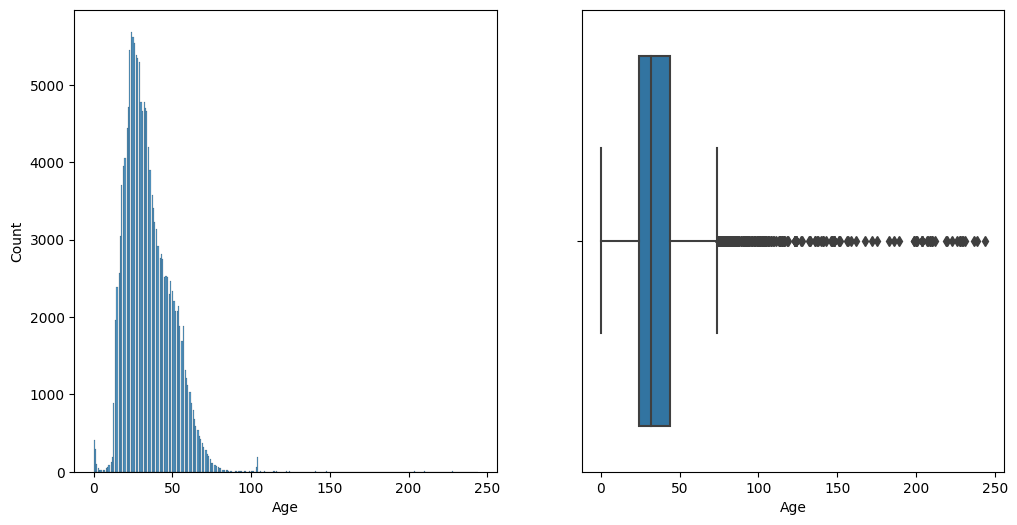

In [34]:
#Histogram showing distribution of ages
fig=plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(x='Age',data=users)

#boxplot of Age column
plt.subplot(1,2,2)
sns.boxplot(x='Age',data=users)

* Most of the users are from the age group 25-50
* It is highly unlikely to have users under the age of 4 and above 100.The peaks near 0 and 100 in the kdeplot indicates that there are some outlier values in the 'Age' column.

It is highly unlikely to have users of age above 95 and below 4 in this case.Let's replace these values with np.nan

In [35]:
#replacing the outliers in 'Age' with NaN value
users.loc[(users['Age']>95)|(users['Age']<4),'Age']=np.nan

In [36]:
#Displaying the current number of missing values in  'Age' column
print('The number of missing values is ',users['Age'].isnull().sum())
#Imputing such a large amount of null values will mean/mode/median will drastically change the distribution
users['Age'].describe()

The number of missing values is  112001


count    166857.000000
mean         34.734222
std          13.621521
min           4.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          95.000000
Name: Age, dtype: float64

In [37]:
# create a normal distribution pd.Series to fill Nan values with
normal_age_series = pd.Series(np.random.normal(loc=users.Age.mean(),
                                               scale=users.Age.std(),
                                               size=users[users.Age.isna()]
                                                ['User-ID'].count()))

# take the absolute value of temp_age_series
abs_age_series=np.abs(normal_age_series)

# sort users df so as NaN values in age to be first and reset index to match with index of abs_age_series. Then using fillna()
users = users.sort_values('Age',na_position='first').reset_index(drop=True)
users.Age.fillna(round(abs_age_series), inplace = True)

In [38]:
users.Age.describe()

count    278858.000000
mean         34.740050
std          13.581844
min           0.000000
25%          25.000000
50%          33.000000
75%          44.000000
max          95.000000
Name: Age, dtype: float64

In [39]:
#percentage of missing values in 'Age' column
(users['Age'].isnull().sum()/len(users))*100

0.0

In [40]:
def age_group(age):
  '''
  defines the age group of users
  '''
  if age<13:
    x='Children'
  elif age>=13 and age<18:
    x='Teens'
  elif age>=18 and age<36:
    x='Youth'
  elif age>=36 and age<56:
    x='Middle aged adults'
  else:
    x='Elderly'
  return x

In [41]:
users['Age_group']=users['Age'].apply(lambda x: age_group(x))

The missing values in the 'Age' column have been imputed with values from a normal distribution.

Now let's inspect the 'Location' column.

In [42]:
#number of unique values in 'Location'
users['Location'].nunique()

57339

In [43]:
#extracting the country names from users_df
for i in users:
    users['Country']=users.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')

In [44]:
#Displaying the country names
set(users['Country'])

{'',
 '01776',
 '02458',
 '19104',
 '23232',
 '30064',
 '85021',
 '87510',
 '_ brasil',
 'a',
 'aaa',
 'adsgfdr',
 'afghanistan',
 'ahrensburg',
 'alachua',
 'albania',
 'alderney',
 'algeria',
 'allen',
 'ama lurra',
 'america',
 'american samoa',
 'andorra',
 'angola',
 'antarctica',
 'aotearoa',
 'argentina',
 'armenia',
 'aroostook',
 'aruba',
 'asturies',
 'auckland',
 'austbritania',
 'australia',
 'australii',
 'austria',
 'autralia',
 'az',
 'azerbaijan',
 'bademn wÃ¼rtemberg',
 'bahamas',
 'bahrain',
 'baltimore',
 'bangladesh',
 'barbados',
 'basilicata',
 'basque country',
 'bavaria',
 'baxter',
 'bbbzzzzz',
 'belarus',
 'belgi',
 'belgique',
 'belgium',
 'belize',
 'bell',
 'benin',
 'berguedÃ\xa0',
 'bermuda',
 'bernalillo',
 'bfe',
 'bhutan',
 'bih',
 'bkk',
 'bladen',
 'bolivia',
 'bosnia',
 'botswana',
 'brasil',
 'brazil',
 'brunei',
 'brunei darussalam',
 'bucks',
 'bulgaria',
 'buncombe',
 'burkina faso',
 'burkinafasu',
 'burlington',
 'burma',
 'butler',
 'c',
 'ca

In [45]:
#correcting the mispelled country names
users.loc[users['Country'].isin(['australii','autralia','western australia']), 'Country'] = 'australia'
users.loc[users['Country'].isin(['unite states','01776','02458','19104','23232','30064','85021','87510','united sates','united staes','united state','united statea','united stated','america'
                                      'united stated of america','united states','united states of america','us','us of a','us virgin islands',
                                      'usa  canada','usa currently living in england','uusa','usaa','wonderful usa','california','orange co']), 'Country'] = 'usa'
users.loc[users['Country'].isin(['united kindgdom', 'united kindgonm','united kingdom','u k']), 'Country'] = 'uk'
users.loc[users['Country'].isin(['the philippines', 'philippines', 'philippinies', 'phillipines', 'phils', 'phippines']), 'Country'] = 'philippines'
users.loc[users['Country'].isin(['','xxxxxx','universe','nowhere','x','y','a','öð¹ú','the','unknown',np.nan,'n/a','aaa','z','somewherein space']), 'Country'] = 'others'
users.loc[users['Country'].isin([ 'italia','italien','itlay']), 'Country'] = 'italy'
users.loc[users['Country'].isin([ ' china öð¹ú','chinaöð¹ú','chian']), 'Country'] = 'china'
users['Country'].replace([ 'the gambia','the netherlands','geermany','srilanka','saudia arabia','brasil','_ brasil','indiai','malaysian','hongkong','russian federation'],
                            ['gambia','netherlands','germany','sri lanka','saudi arabia','brazil','brazil','india','malaysia','hong kong','russia'],inplace=True)


In [46]:
#Converting the country names to uppercase
users['Country']=users['Country'].str.upper()

In [47]:
#Dropping the column 'Location'
users.drop('Location',axis=1,inplace=True)

In [48]:
users.columns

Index(['User-ID', 'Age', 'Age_group', 'Country'], dtype='object')

In [49]:
users.Country.value_counts()

USA               139746
CANADA             21658
UK                 18565
GERMANY            17074
SPAIN              13258
                   ...  
THAILOAND              1
ROSARIO                1
BURKINAFASU            1
ADSGFDR                1
SAN BERNARDINO         1
Name: Country, Length: 464, dtype: int64

#**Ratings Data**


---
**Data Description**

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


In [50]:
#displaying the first 5 rows
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [51]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [52]:
# checking null values
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [53]:
# checking for unique user ids and isbn values
print('Number of unique user ids is {} and ISBN no. is {}'.format(ratings['User-ID'].nunique(),
                                                                  ratings['ISBN'].nunique()))

Number of unique user ids is 105283 and ISBN no. is 340556


This means that many users are buying multiple books. Also some books are really famous and hence are bought by multiple users.

In [54]:
# making all the ISBN no. uppercase
ratings['ISBN'].apply(lambda x: x.upper())

0           034545104X
1           0155061224
2           0446520802
3           052165615X
4           0521795028
              ...     
1149775     1563526298
1149776     0679447156
1149777     0515107662
1149778     0590442449
1149779    05162443314
Name: ISBN, Length: 1149780, dtype: object

In [55]:
# checking for duplicates
ratings[ratings.duplicated()].sum()

User-ID        0.0
ISBN           0.0
Book-Rating    0.0
dtype: float64

In [56]:
# lets see if all the books in rating_df are also in books_df
ratings_new = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [57]:
print('Shape of rating_df: {} and ratings_new: {}'.format(ratings.shape,
                                                            ratings_new.shape))

Shape of rating_df: (1149780, 3) and ratings_new: (1030617, 3)


In [58]:
# book ratings
ratings_new['Book-Rating'].value_counts().reset_index()

,index,Book-Rating
0,0,646974
1,8,91739
2,10,71194
3,7,66356
4,9,60754
5,5,45343
6,6,31673
7,4,7613
8,3,5117
9,2,2374


We can see for explicit ratings that rating 8 is received by most number of books followed by rating 10. There are 646974 implicitely rated books.

In [59]:
# most popular books
ratings_new.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating',
                                                                               ascending=False)[:10]

,ISBN,Book-Rating
215608,0971880107,2502
38505,0316666343,1295
70686,0385504209,883
7325,0060928336,732
32311,0312195516,723
87235,044023722X,647
21293,0142001740,615
144784,067976402X,614
132908,0671027360,586
93670,0446672211,585


But this contains both explicit and implicit rating, so we need to seperate them to get better idea.

In [60]:
explicit_rating = ratings_new[ratings_new['Book-Rating'] != 0]
implicit_rating = ratings_new[ratings_new['Book-Rating'] == 0]
print('Shape of explicit rating: {} and implicit rating: {}'.format(explicit_rating.shape, implicit_rating.shape))

Shape of explicit rating: (383643, 3) and implicit rating: (646974, 3)


In [61]:
# most purchased books including the implicitely rated books
ratings_new.groupby('ISBN')['User-ID'].count().reset_index().sort_values(by='User-ID',
                                                                           ascending=False)[:10]['ISBN'].values

array(['0971880107', '0316666343', '0385504209', '0060928336',
       '0312195516', '044023722X', '0142001740', '067976402X',
       '0671027360', '0446672211'], dtype=object)

In [62]:
# getting the book names corresponding to these ISBNs
isbn_nums = ['0971880107', '0316666343', '0385504209', '0060928336',
       '0312195516', '044023722X', '0142001740', '067976402X',
       '0671027360', '0446672211']
books[books['ISBN'].isin(isbn_nums)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
118,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...
305,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...,http://images.amazon.com/images/P/044023722X.0...
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
1922,067976402X,Snow Falling on Cedars,David Guterson,1995.0,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...


In [63]:
# most popular explicitely rated books
explicit_rating.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating',
                                                                                 ascending=False)[:10]

,ISBN,Book-Rating
21915,0316666343,707
117593,0971880107,581
38771,0385504209,487
18032,0312195516,383
4122,0060928336,320
68795,059035342X,313
12303,0142001740,307
51715,0446672211,295
47910,044023722X,281
57539,0452282152,278


In [64]:
# getting the book names corresponding to these ISBNs
isbn_nums = ['0316666343', '0971880107', '0385504209', '0312195516', '0060928336']
books[books['ISBN'].isin(isbn_nums)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...


#**Merging Datasets**


---
Now we are going to merge the 3 dataset given to us to analyse them and work on them.



In [116]:
# for the rating dataset, we are only taking the explicit rating dataset
df = pd.merge(books, explicit_rating, on='ISBN', how='inner') #books and rating on ISBN
df = pd.merge(df, users, on='User-ID', how='inner') #above df with users on user-ID

In [117]:
#shape of the merged dataframe 'df'
df.shape

(383693, 13)

In [118]:
#displaying the top 3 rows of df
df.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,Age_group,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,30.0,Youth,CANADA
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,8,5,30.0,Youth,CANADA
2,0887841740,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,8,5,30.0,Youth,CANADA


In [119]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Age', 'Age_group', 'Country'],
      dtype='object')

In [120]:
# Dropping unwanted columns from our dataframe 'df'
df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace= True)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383693 entries, 0 to 383692
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 383693 non-null  object 
 1   Book-Title           383693 non-null  object 
 2   Book-Author          383693 non-null  object 
 3   Year-Of-Publication  383693 non-null  float64
 4   Publisher            383693 non-null  object 
 5   User-ID              383693 non-null  int64  
 6   Book-Rating          383693 non-null  int64  
 7   Age                  383693 non-null  float64
 8   Age_group            383693 non-null  object 
 9   Country              383693 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 32.2+ MB


#**Exploratory Data Analysis**

<Axes: title={'center': '\nMost popular ratings\n'}, xlabel='Book-Rating', ylabel='count'>

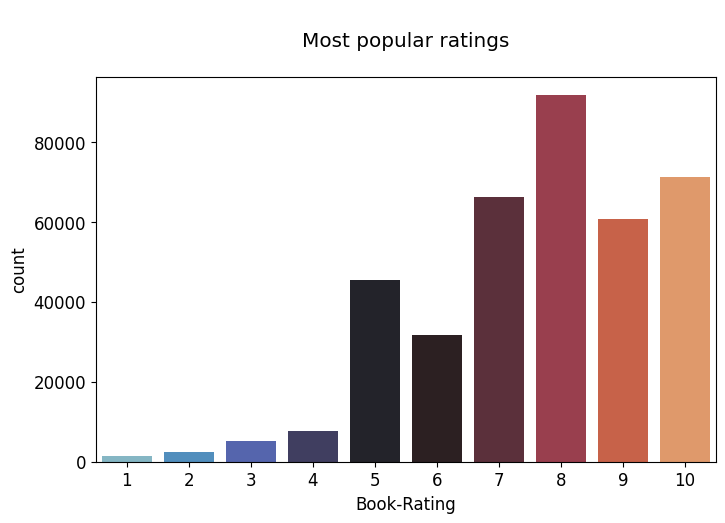

In [71]:
# most popular rating
plt.figure(figsize=[8,5])
plt.rc('font', size=12)
plt.title('\nMost popular ratings\n')
sns.countplot(data=df, x='Book-Rating', palette = 'icefire')

* Most of users have given above 4 ratings to books
* 8 is the most common rating given by users
* A considerable amount of books have gotten 10 rating.

<Axes: title={'center': '\nMost popular books\n'}, xlabel='Count', ylabel='Book-Title'>

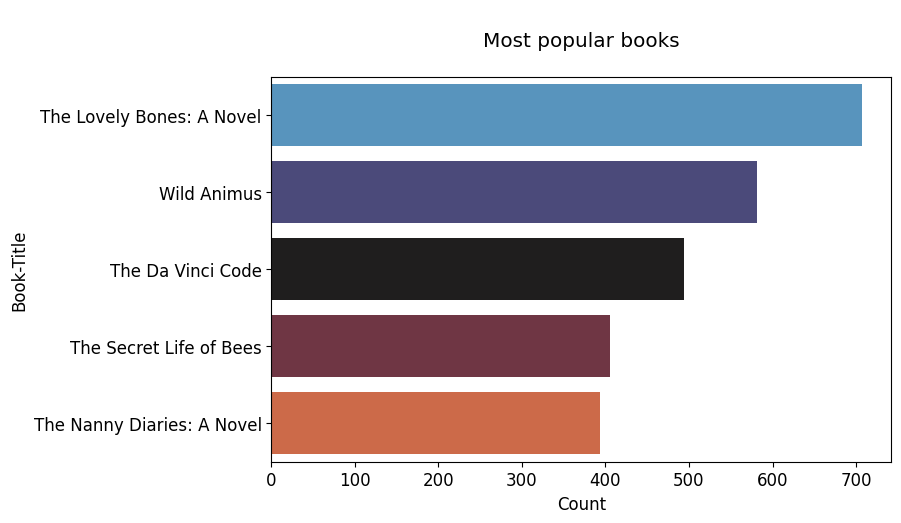

In [72]:
# top 5 most popular books

popular = df.groupby('Book-Title')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating', ascending=False)[:5]
popular.columns = ['Book-Title', 'Count']

plt.figure(figsize=[8, 5])
plt.rc('font', size=12)
plt.title('\nMost popular books\n')
sns.barplot(data=popular, y='Book-Title', x='Count', palette = 'icefire')


* **"The lovely bones"** is the book which has been rated by most umber of users.

<Axes: title={'center': '\nMost popular Authors\n'}, xlabel='Book-Rating', ylabel='Book-Author'>

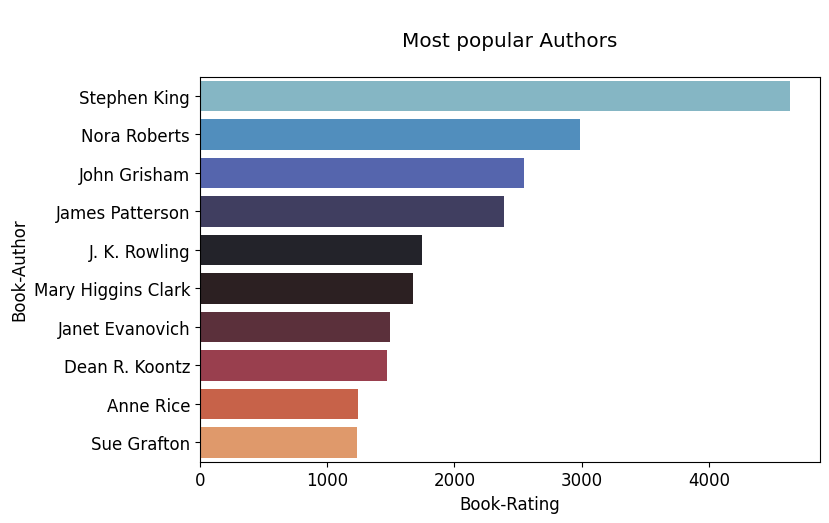

In [73]:
# most popular book authors
author = df.groupby('Book-Author')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating', ascending=False)[:10]
plt.figure(figsize=[8, 5])
plt.rc('font', size=12)
plt.title('\nMost popular Authors\n')
sns.barplot(data=author, y='Book-Author', x='Book-Rating',palette='icefire')

* **Stephen King** is the most popular author with respect to number of ratings given to the books.

<Axes: xlabel='Age', ylabel='Density'>

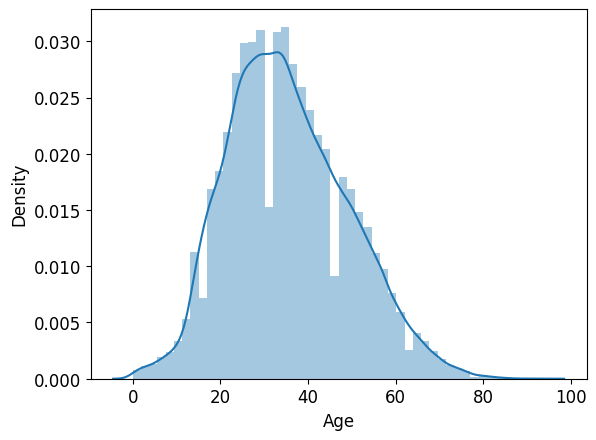

In [74]:
#Age distribution of users
age = users[users['User-ID'].isin(list(df['User-ID'].unique()))]
sns.distplot(age.Age)

* The majority of readers are between the ages of 20 and 40.
* Readers who are 80 to 100 years old make up a tiny minority.

In [75]:
#value counts of country
countries=users['Country'].value_counts().reset_index().head(10)
countries.rename(columns={'index':'Country','Country':'Count'},inplace=True)
countries

,Country,Count
0,USA,139746
1,CANADA,21658
2,UK,18565
3,GERMANY,17074
4,SPAIN,13258
5,AUSTRALIA,11787
6,ITALY,11284
7,OTHERS,5051
8,FRANCE,3487
9,PORTUGAL,3390


Text(0.5, 0, 'No of users')

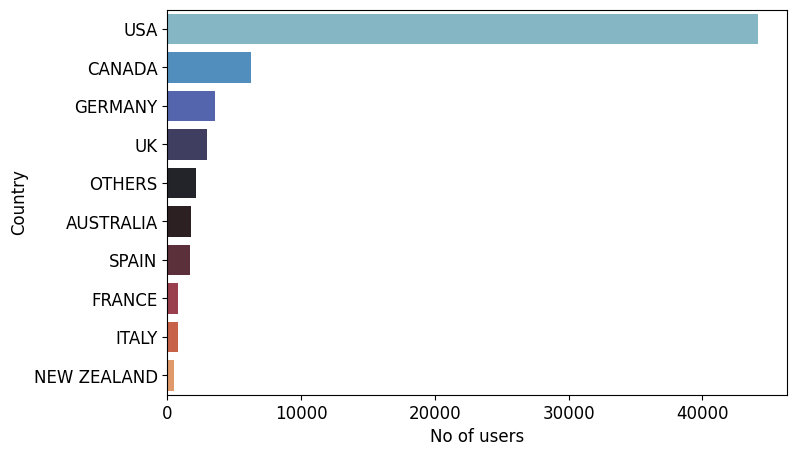

In [76]:
# countries with most readers
plt.figure(figsize=[8, 5])
countries = df.groupby('Country')['User-ID'].nunique().reset_index().sort_values(by='User-ID', ascending=False)[:10]
sns.barplot(data=countries, y='Country', x='User-ID',palette='icefire')
plt.xlabel('No of users')

In [77]:
# Importing required library
import plotly.graph_objects as go

In [78]:
# Creating dataframe for Publisher
countries = pd.DataFrame(df['Country'].value_counts().sort_values(ascending=False))
countries = countries.rename(columns={'Country':'count'})

In [79]:
# Plotting the interactive pie plot in percentage of Top 10 countries
data = {
   "values": countries['count'][:10],
   "labels": countries.index[:10],
   "domain": {"column": 0},
   "name": "Country Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Percentage of Countries</b>", legend=dict(x=0.1, y=1.0, orientation="v"))
data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

* Most of the readers are from the United States followed by Canada.

In [80]:
#How many users have rated atleast 1 book?
df['User-ID'].value_counts()

11676     6940
98391     5692
189835    1899
153662    1846
23902     1180
          ... 
37259        1
53095        1
51124        1
235548       1
259679       1
Name: User-ID, Length: 68080, dtype: int64

There are 68080 users who have read and rated atleast 1 book.

In [81]:
df.groupby('User-ID')['Book-Rating'].count().describe()

count    68080.000000
mean         5.635914
std         41.736965
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       6940.000000
Name: Book-Rating, dtype: float64

<Axes: xlabel='Book-Title', ylabel='Publisher'>

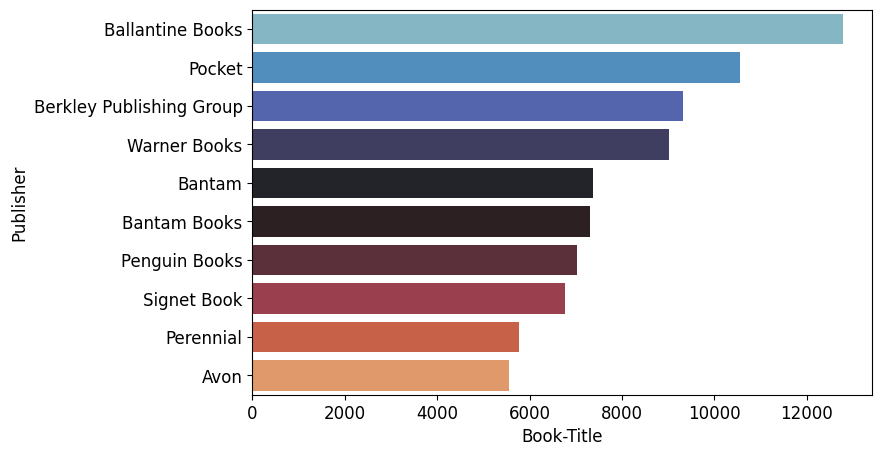

In [82]:
# Publisher with most books

publishers = df.groupby('Publisher')['Book-Title'].count().reset_index().sort_values(by='Book-Title', ascending=False)[:10]
plt.figure(figsize=[8, 5])
sns.barplot(data=publishers, x='Book-Title', y='Publisher',palette='icefire')


In [83]:
# Creating dataframe for Publisher
publishers = pd.DataFrame(df['Publisher'].value_counts().sort_values(ascending=False))
publishers = publishers.rename(columns={'Publisher':'count'})

In [84]:
# Plotting the interactive pie plot in percentage of Top 20 publishers
data = {
   "values": publishers['count'][:20],
   "labels": publishers.index[:20],
   "domain": {"column": 0},
   "name": "Publisher Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Percentage of Publisher</b>", legend=dict(x=0.1, y=1.0, orientation="v"))
data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

* Ballantine Books is most popular publisher based on the number of users who have rated their books.

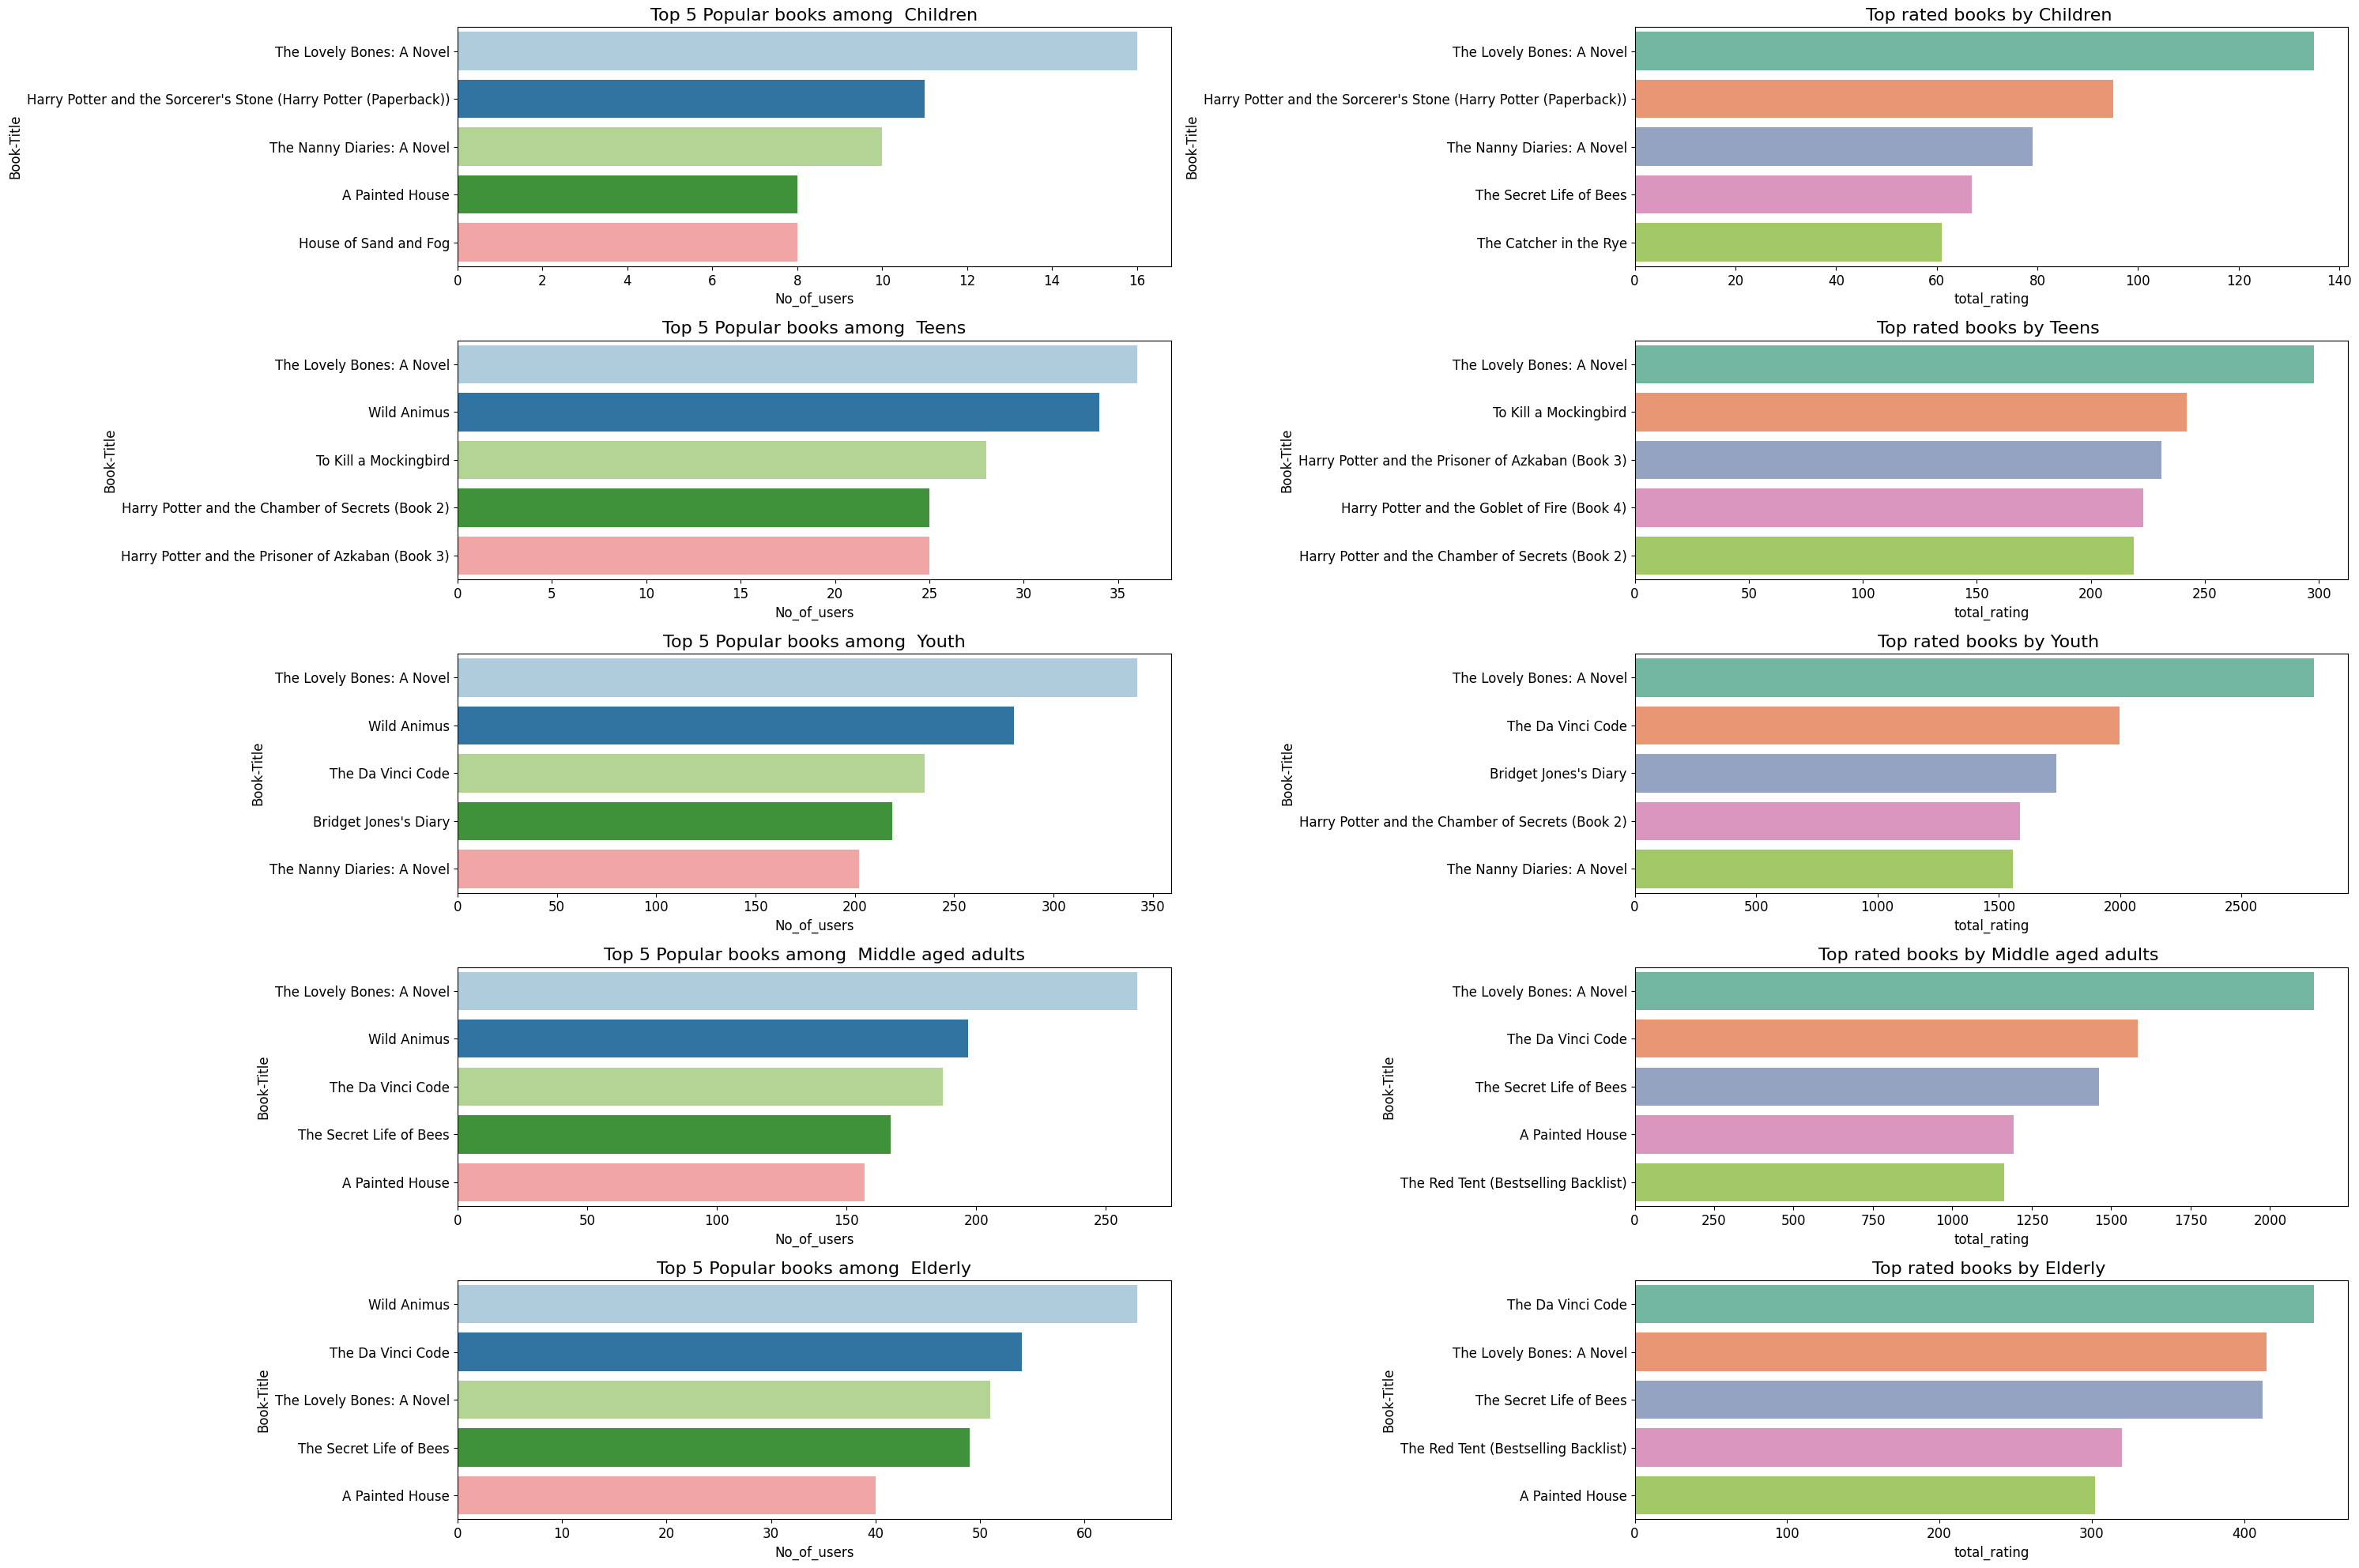

In [85]:
fig=plt.figure(figsize=(30,20))
i=1
for group  in ['Children','Teens','Youth','Middle aged adults','Elderly']:
  age=df.loc[df['Age_group']==group].groupby(['Book-Title']).agg(No_of_users=('User-ID','nunique'),total_rating=('Book-Rating','sum')).reset_index()
  plt.subplot(5,2,i)
  age.sort_values(by='No_of_users',ascending=False,inplace=True)
  sns.barplot(x='No_of_users',y='Book-Title',palette='Paired',data=age.head(5))
  plt.title('Top 5 Popular books among  {}'.format(group),size=16)
  i= i + 1
  plt.subplot(5,2,i)
  age.sort_values(by='total_rating',ascending=False,inplace=True)
  sns.barplot(x='total_rating',y='Book-Title',palette='Set2',data=age.head(5))
  plt.title('Top rated books by {} '.format(group),size=16)
  i+=1

plt.tight_layout()

In [86]:
pub_year = df['Year-Of-Publication'].value_counts().head(20).astype(int)
pub_year

2002.0    37975
2001.0    32317
2003.0    29197
1999.0    29081
2000.0    28310
1996.0    27150
1998.0    24619
1997.0    21844
1995.0    19090
1994.0    16588
1993.0    13350
1992.0    12387
1991.0    11322
1990.0    10457
2004.0    10094
1989.0     8294
1988.0     6853
1987.0     6158
1986.0     5585
1984.0     4583
Name: Year-Of-Publication, dtype: int64

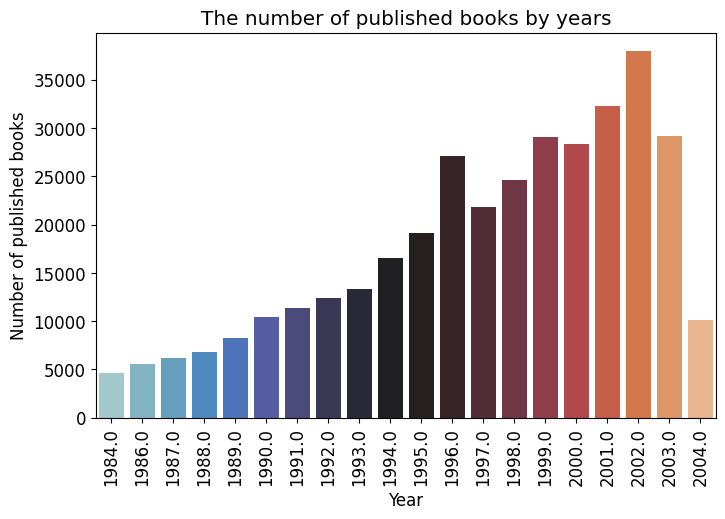

In [87]:
plt.figure(figsize=(8,5))
sns.barplot(x=pub_year.index,y=pub_year, palette = 'icefire')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of published books')
plt.title('The number of published books by years')
plt.show()

The year 2002 marks the highest number of published books.

#**EDA CONCLUSIONS**


---

* The Lovely Bones: A Novel and Wild Animus are the two most read books.
* Most popular book author based on the number of ratings is Stephan King .
* Ballantine Books and Pocket are the top publishers based on the number of ratings that their books have received.
* The majority of readers are between the ages of 20 and 40.
* The majority of readers who have given the books ratings are from the United States and Canada.
* Regardless of the age group, The Lovely Bones and Wild animus appear on lists of the top-rated books.



#**Recommendation System**


---

##**Popularity Based**

It is a type of recommendation system that bases choices on factors like popularity and/or current trends.




##**Simple Popularity based recommendation system**

In [88]:
# function for getting most popular recommendations

def most_popular(df, n):
  if n >= 1 and n <= len(df):
    popular = df.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values(by='Book-Rating', ascending=False).head(n)
    return pd.merge(popular, books, on='ISBN')
  return 'Please enter a valid value of n!'

In [90]:
most_popular(df, 4)

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
1,0971880107,581,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
2,0385504209,487,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


##**Country based Book Recommendation**

In [91]:
# function for getting most popular recommendations country wise

def country_popular(df, country):
  if country in list(df.Country.unique()):
    return most_popular(df[df['Country'] == country], 5) # calling most_popular function to get popular recommendations
  return 'This country is not present in the dataset. Please enter some other country.'


In [93]:
country_popular(df, 'USA')

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0316666343,532,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
1,0385504209,393,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
2,0312195516,302,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
3,0971880107,300,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
4,0142001740,271,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...


##**weighted Average Rating Method**

Using Weighted average for each Book’s Average Rating

**W = (Rv + Cm)/(v + m)**

where,

**W** = Weighted Rating

**R** = Average of the Books rating

**v** = No of people who have rated the books(number of votes)

**m** = minimum no of votes to be listed

**C** = the mean rating across all the books

In [94]:
#finding the average rating and number of votes received by books
df_relevant_data = df.groupby(['Book-Title','Book-Author'],as_index=False).agg(avg_rating=('Book-Rating','mean'),ratings_count=('Book-Rating','count'))
v=df_relevant_data['ratings_count']
R=df_relevant_data['avg_rating']
C=df_relevant_data['avg_rating'].mean()
m=int(df_relevant_data['ratings_count'].quantile(0.90))#minimum number of votes to be listed
print(f'The average rating of all the books is {C} and the minimum number of votes required by the books to be listed is {m}  ')


The average rating of all the books is 7.521950458813911 and the minimum number of votes required by the books to be listed is 4  


In [95]:
#Calculating weighted average rating of the books
df_relevant_data['weighted_average']=round(((R*v)+ (C*m))/(v+m),2)

In [96]:
df_relevant_data.sort_values(by='weighted_average',ascending=False).head(10)

,Book-Title,Book-Author,avg_rating,ratings_count,weighted_average
46689,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,9.869565,23,9.52
122637,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,9.653846,52,9.50
30266,Dilbert: A Book of Postcards,Scott Adams,9.923077,13,9.36
82074,Postmarked Yesteryear: 30 Rare Holiday Postcards,Pamela E. Apkarian-Russell,10.000000,11,9.34
118589,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,9.402597,77,9.31
17792,Calvin and Hobbes,Bill Watterson,9.583333,24,9.29
101274,The Authoritative Calvin and Hobbes (Calvin an...,Bill Watterson,9.600000,20,9.25
72894,"My Sister's Keeper : A Novel (Picoult, Jodi)",Jodi Picoult,9.545455,22,9.23
118585,"The Return of the King (The Lord of The Rings,...",J. R. R. Tolkien,9.625000,16,9.20
109214,The Giving Tree,Shel Silverstein,9.423077,26,9.17


This is the list of most favored books based on the weighted rating scores. The book 'Harry Potter and the Chamber of Secrets Postcard Book' seems to have top this chart.

##**Author Based Recommender System**


In [97]:
def author_based(book_title,number,df_relevant_data=df_relevant_data):
  '''
  To recommend books from the same author as the book entered by the user
  '''
  author=df_relevant_data.loc[df_relevant_data['Book-Title']==book_title]['Book-Author'].unique()[0]
  author_df=df_relevant_data.loc[(df_relevant_data['Book-Author']==author)].sort_values(by='weighted_average',ascending=False)
  print(f'The author of the book {book_title} is {author}\n')
  print(f'Here are the top {number} books from the same author\n')
  top_rec=author_df.loc[(author_df['Book-Title']!=book_title),['Book-Title','weighted_average']].head(number)
  return(top_rec)

In [100]:
#get book name and number of books to recommend
book_title = 'The Two Towers (The Lord of the Rings, Part 2)'
number =5
author_based(book_title,number)# top_recommendations from the same author

The author of the book The Two Towers (The Lord of the Rings, Part 2) is J. R. R. Tolkien

Here are the top 5 books from the same author



,Book-Title,weighted_average
118585,"The Return of the King (The Lord of The Rings,...",9.20
113370,The Lord of the Rings (Leatherette Collector's...,9.01
110604,The Hobbit,8.98
108073,The Fellowship of the Ring (Lord of the Rings ...,8.93
108075,The Fellowship of the Ring (The Lord of the Ri...,8.85


#**Collaborative Filtering**

This recommendation based on collaborative filtering with KNN model.

Collaborative filtering method builds a model from a user’s past behaviors (items previously purchased or selected and/or numerical ratings given to those items) as well as similar decisions made by other users. Then this model is used to predict items (or ratings for items) that the user may have an interest in. The method can either be user-based or item-based.

To apply an item based collaborative filtering I use a KNN algorithm which is a perfect model and also a very good baseline for recommender system development.


#**Memory Based Approach**

##**KNN Based Algorithm**

In [122]:
# we kept running into memory issues, so decided to reduce some data by filtering things out
# focussing on users with more than 3 ratings and top 10% most frequently rated books
required_ratings = 3

user = df['User-ID'].value_counts()
user_list = user[user >required_ratings].index.to_list()
filter_df = df[df['User-ID'].isin(user_list)]

print('Number of users with ratings more than 3 are: {}'.format(filter_df.shape[0]))

Number of users with ratings more than 3 are: 313417


In [123]:
# top 10% most frequently rated books
required = len(filter_df.ISBN.unique()) * 0.1

user_list = filter_df['Book-Title'].value_counts().head(int(required)).index.to_list()
filter_df = filter_df[filter_df['Book-Title'].isin(user_list)]

print('Number of top 10% users are: {}'.format(filter_df.shape[0]))

Number of top 10% users are: 167394


In [125]:
# shape of final dataset
filter_df.shape

(167394, 10)

In [126]:
# creating a pivot table
table = filter_df.pivot_table(columns='User-ID', index='Book-Title', values='Book-Rating')
table

User-ID,8,17,53,99,114,183,232,242,243,244,...,278633,278637,278648,278663,278668,278694,278773,278843,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Yo!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
".Hack: //Legend of the Twilight, Vol. 1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iI Paradiso Degli Orchi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
one hundred years of solitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# filling null values
table.fillna(0, inplace=True)
table

User-ID,8,17,53,99,114,183,232,242,243,244,...,278633,278637,278648,278663,278668,278694,278773,278843,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Yo!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
".Hack: //Legend of the Twilight, Vol. 1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
one hundred years of solitude,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
# converting to sparse matrix
from scipy.sparse import csr_matrix

sparse = csr_matrix(table)
sparse

<13403x14947 sparse matrix of type '<class 'numpy.float64'>'
	with 166539 stored elements in Compressed Sparse Row format>

In [129]:
#Creating an instance of KNN
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(algorithm='brute')
model.fit(sparse)

NearestNeighbors(algorithm='brute')

In [130]:
# function to get recommendations

def get_recommendations(name, n):

  # getting book id
  book_id= np.where(table.index==name)[0][0]

  # distances and suggestions based on similarity
  distances, suggestions = model.kneighbors(table.iloc[book_id, :].values.reshape(1,-1),n_neighbors=n+1)
  suggestions = suggestions.flatten().tolist()

  for i in range(len(suggestions)):
    # if book is same as input
    if i==0:
      print('The top {} Recommended books for {} are:\n'.format(n, name))
    else:
      print(table.index[suggestions[i]])
  return

In [131]:
get_recommendations('Harry Potter and the Chamber of Secrets (Book 2)', 10)

The top 10 Recommended books for Harry Potter and the Chamber of Secrets (Book 2) are:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Book 1)
Dr. Seuss's A B C (I Can Read It All by Myself Beginner Books)
The Second Generation
Lover Beware
J. K. Rowling: The Wizard Behind Harry Potter
A Dash of Death
So Much to Tell You
Dragonquest Achille Cover


#**KNN with Cosine Metric**

In [132]:
#Creating an instance of KNN with cosine metric

model_cosine = NearestNeighbors(metric='cosine', algorithm='brute')
model_cosine.fit(sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [133]:
# function to get recommendations

def get_cosine_recommendations(name, n):

  print('Cosine Similarity based recommendations.\n')

  # distances and indices based on similarity
  distances, indices = model_cosine.kneighbors(table.loc[name].values.reshape(1, -1), n_neighbors = n+1)

  for i in range(len(distances.flatten())):
    if i==0:
      print('The top {} Recommended books for {} are:\n'.format(n, name))
    else:
      print(table.index[indices.flatten()[i]])
  return

In [134]:
get_cosine_recommendations('Harry Potter and the Chamber of Secrets (Book 2)', 10)

Cosine Similarity based recommendations.

The top 10 Recommended books for Harry Potter and the Chamber of Secrets (Book 2) are:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Hobbit: or There and Back Again
The Two Towers (The Lord of the Rings, Part 2)
Dr. Seuss's A B C (I Can Read It All by Myself Beginner Books)
The Second Generation


#**KNN Location Based**

Using KNN algorithm, clusters of similar users based on common book ratings can be found and predictions can be made using the average rating of the top-k nearest neighbors.

In [135]:
book_rating = df[['User-ID','ISBN','Book-Rating','Book-Title']]
print(book_rating.info())
print(book_rating.shape)
print(book_rating.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383693 entries, 0 to 383692
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      383693 non-null  int64 
 1   ISBN         383693 non-null  object
 2   Book-Rating  383693 non-null  int64 
 3   Book-Title   383693 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.6+ MB
None
(383693, 4)
   User-ID        ISBN  Book-Rating  \
0        8  0002005018            5   
1        8  074322678X            5   
2        8  0887841740            5   
3        8  1552041778            5   
4        8  1567407781            6   

                                     Book-Title  
0                                  Clara Callan  
1       Where You'll Find Me: And Other Stories  
2                            The Middle Stories  
3                                      Jane Doe  
4  The Witchfinder (Amos Walker Mystery Series)  


In [136]:
book_rating = book_rating.dropna(axis=0, subset= ['Book-Title'])
book_ratingCount = (book_rating.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().rename(columns = {'Book-Rating' : 'totalRatingCount'})[['Book-Title', 'totalRatingCount']])
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Dark Justice,1
3,Earth Prayers From around the World: 365 Pray...,7
4,Final Fantasy Anthology: Official Strategy Gu...,2


In [137]:
rating_with_totalRatingCount = book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how ='left')
rating_with_totalRatingCount.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,8,0002005018,5,Clara Callan,9
1,8,074322678X,5,Where You'll Find Me: And Other Stories,1
2,8,0887841740,5,The Middle Stories,1
3,8,1552041778,5,Jane Doe,2
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),1


In [138]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   135510.000
mean         2.831
std          9.134
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        707.000
Name: totalRatingCount, dtype: float64


In [139]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    5.000
0.920    5.000
0.930    6.000
0.940    7.000
0.950    8.000
0.960   10.000
0.970   13.000
0.980   17.000
0.990   29.000
Name: totalRatingCount, dtype: float64


In [140]:
popularity_threshold = 100
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
8,11676,0399135782,9,The Kitchen God's Wife,115
10,11676,0440234743,9,The Testament,261
14,11676,0971880107,6,Wild Animus,581
15,11676,0345417623,10,Timeline,263
17,11676,0449005615,10,Seabiscuit: An American Legend,133


##**Filtering to users in top 2 countries - USA and Canada**

In [142]:
combined = rating_popular_book.merge(users, left_on ='User-ID', right_on= 'User-ID', how='left')

us_canada_user_rating = combined[combined['Country'].str.contains("USA|CANADA")]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis = 1)

us_canada_user_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount,Age_group,Country
225,67544,0316569321,7,White Oleander : A Novel,177,Youth,CANADA
226,67544,0316601950,8,The Pilot's Wife : A Novel,272,Youth,CANADA
229,210926,0440212561,10,Outlander,139,Middle aged adults,CANADA
230,263325,0446310786,10,To Kill a Mockingbird,267,Youth,CANADA
231,263325,0786868716,8,The Five People You Meet in Heaven,244,Youth,CANADA


##**Implementing KNN**

In [143]:
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot_table(index = 'Book-Title', columns= 'User-ID', values = 'Book-Rating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [144]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [145]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

for i in range(0, len(distances.flatten())):
    if i==0:
        print('Recommendations for', format(us_canada_user_rating_pivot.index[query_index]), ':')
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]],distances.flatten()[i]))

Recommendations for Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel) :
1: Seven Up (A Stephanie Plum Novel), with distance of 0.6423571198422866:
2: Four To Score (A Stephanie Plum Novel), with distance of 0.7710048982689168:
3: Two for the Dough, with distance of 0.8137205067357002:
4: One for the Money (Stephanie Plum Novels (Paperback)), with distance of 0.8672549757710125:
5: Full House (Janet Evanovich's Full Series), with distance of 0.8999371061064356:


#**Model Based Approach**


---

##**Singular Value Decomposition**

The Singular Value Decomposition (SVD) of a matrix is a factorization of that matrix into three matrices. It has some interesting algebraic properties and conveys important geometrical and theoretical insights about linear transformations.

One of the main applications of SVD is to reduce the dimensionality of a dataset. By finding the basic patterns in the data and discarding the less important ones, SVD can help simplify the data and make it easier to work with.


In [146]:
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import random
import math

##**Filtering the number of books and users**

In [147]:
#Filtering books with more than 5 reviews

print('The number of books that are explicitely rated are',explicit_rating['ISBN'].nunique())
ratings_count_df=explicit_rating.groupby("ISBN")['User-ID'].count().to_frame('No-of-rated-users').reset_index()
selected_books =list(ratings_count_df.loc[ratings_count_df['No-of-rated-users']>5,'ISBN'].unique())
print('Number of  books rated by atleast 5 users:',len(selected_books))
filter_df=explicit_rating.loc[explicit_rating['ISBN'].isin(selected_books)]


The number of books that are explicitely rated are 149655
Number of  books rated by atleast 5 users: 10731


In [148]:
#keeping books with selected users
print('The number of users who have explicitely rated books are',explicit_rating['User-ID'].nunique())

#keeps Users who have rated more than five books
books_count_df=filter_df.groupby("User-ID")['ISBN'].count().to_frame('No-of-books-rated').reset_index()
selected_users = list(books_count_df.loc[books_count_df['No-of-books-rated']>5,'User-ID'].unique())
print('Number of  users who have rated atleast 5 books are :',len(selected_users))

#dataframe with filtered number of interactions
filter_df=filter_df.loc[filter_df['User-ID'].isin(selected_users)]
print('The shape of data fame with filtered number of interactions : ',filter_df.shape)


The number of users who have explicitely rated books are 68080
Number of  users who have rated atleast 5 books are : 5911
The shape of data fame with filtered number of interactions :  (114147, 3)


In [149]:
complete_df = filter_df.copy()

In [150]:
complete_df['Book-Rating'].describe()

count   114147.000
mean         7.817
std          1.774
min          1.000
25%          7.000
50%          8.000
75%          9.000
max         10.000
Name: Book-Rating, dtype: float64

In [151]:
def smooth_user_preference(x):
    '''Function to smooth column'''
    return math.log(1+x, 2)
#applying function
complete_df['Book-Rating']= complete_df['Book-Rating'].apply(smooth_user_preference)
complete_df.head()

,User-ID,ISBN,Book-Rating
177,276847,3404148576,3.170
179,276847,3423071516,3.459
186,276847,3442413508,3.459
189,276847,3442437717,3.000
190,276847,3442441080,3.459


In [152]:
train_df, test_df = train_test_split(complete_df,
                                   stratify=complete_df['User-ID'],
                                   test_size=0.20,
                                   random_state=0)

print('# interactions on Train set: %d' % len(train_df))
print('# interactions on Test set: %d' % len(test_df))

# interactions on Train set: 91317
# interactions on Test set: 22830


In [153]:
#displaying the first 5 rows of test set
test_df.head()

,User-ID,ISBN,Book-Rating
595435,143415,0804117683,2.585
1129708,271195,0061091502,3.170
921324,224430,0446675059,3.322
963425,232492,0553580191,3.459
415865,98783,0553290797,3.170


In [154]:
#Creating a sparse pivot table with users in rows and ISBN number of books in columns
users_books_pivot_matrix_df = train_df.pivot(index='User-ID',
                                                          columns='ISBN',
                                                          values='Book-Rating').fillna(0)

users_books_pivot_matrix_df.head()

ISBN,0002005018,0002251760,0002259834,0002558122,0006480764,000648302X,000649840X,0006546684,0006547834,0006550576,...,881787017X,8838910170,8845205118,8845247414,8845915611,9074336329,950491036X,9681500555,968150108X,9726101794
User-ID,,,,,,,,,,,,,,,,,,,,,
114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
243,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
244,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
254,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
388,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [155]:
#Creating a matrix with the values of users_books_pivot_matrix_df
original_ratings_matrix = users_books_pivot_matrix_df.values
original_ratings_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [156]:
#Storing the User-IDs in a list
user_ids = list(users_books_pivot_matrix_df.index)
user_ids[:10]

[114, 243, 244, 254, 388, 446, 503, 505, 507, 638]

In [157]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(original_ratings_matrix, k = NUMBER_OF_FACTORS_MF)


In [158]:
#converting sigma to a diagonal matrix
sigma = np.diag(sigma)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It has generated rating predictions for books with which users have not yet interacted (and therefore not rated), which we will use to recommend relevant books to the user.

In [159]:
#Rating matric reconstructed using the matrices obtained after factorizing
predicted_ratings_matrix = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_matrix

array([[-4.04258460e-03,  5.55244996e-03,  3.55055121e-04, ...,
         1.50895745e-03,  2.40835026e-03, -4.47942990e-04],
       [ 2.39738748e-03,  7.31390062e-03,  1.06721793e-03, ...,
         2.41422467e-03, -2.50155111e-03,  7.07560167e-04],
       [ 2.76172022e-03,  2.46976045e-03,  3.93502515e-04, ...,
         7.51697062e-05, -3.15196343e-04,  4.15219598e-04],
       ...,
       [-3.77213135e-03,  4.35044249e-03,  7.91362149e-04, ...,
        -1.50838380e-03,  3.13716934e-04,  7.99373179e-05],
       [-9.99820694e-04, -5.55826794e-03, -1.68973261e-04, ...,
        -2.70869693e-04, -2.11730260e-03,  7.02884677e-03],
       [ 3.24745355e-03,  2.10480356e-03, -1.81779252e-04, ...,
        -3.05056878e-03, -1.71475791e-04,  2.70358799e-04]])

In [160]:
#Converting the reconstructed matrix back to a Pandas dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix , columns = users_books_pivot_matrix_df.columns, index=user_ids).transpose()
predicted_ratings_df.head()

,114,243,244,254,388,446,503,505,507,638,...,278221,278314,278356,278390,278418,278535,278554,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,-0.004,0.002,0.003,-0.004,-0.000,-0.000,0.002,-0.001,0.005,0.014,...,0.001,0.001,-0.001,0.002,0.002,0.002,0.000,-0.004,-0.001,0.003
0002251760,0.006,0.007,0.002,0.021,0.001,0.001,0.002,0.004,0.004,0.015,...,-0.000,0.001,-0.001,0.005,-0.005,-0.000,0.001,0.004,-0.006,0.002
0002259834,0.000,0.001,0.000,0.002,0.000,0.000,0.000,-0.000,0.000,0.000,...,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.001,-0.000,-0.000
0002558122,-0.004,-0.003,0.002,-0.005,-0.000,-0.001,0.001,-0.000,0.002,0.014,...,-0.000,0.001,0.002,0.002,0.002,0.004,0.000,-0.005,-0.002,0.003
0006480764,-0.000,0.003,0.001,0.001,-0.000,0.000,0.001,-0.000,0.001,0.009,...,0.000,0.000,-0.002,-0.000,0.000,-0.000,0.000,0.000,0.009,-0.001


#**Building Recommender Model**

In [161]:
class CFRecommender:
    #Storing model name
    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        #Creating attributes
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        '''This will return model name'''
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'Book-Rating'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('Book-Rating', ascending = False).head(topn)

        if verbose:
            #runs only if verbose=True
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            #Merging
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'ISBN',
                                                          right_on = 'ISBN')[["ISBN",'Book-Title',	'Book-Author','Publisher']]

        return recommendations_df

#Creating object of the class
cf_recommender_model = CFRecommender(predicted_ratings_df, books)

In [162]:
def get_items_interacted(person_id, interactions_df):
    '''
    This function will take user id as input and return interacted items
    '''
    interacted_items = interactions_df.loc[person_id]['ISBN']
    #Repetation is avoided by taking set
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


In [163]:
#Indexing by personId to speed up the searches during evaluation
full_indexed_df =complete_df.set_index('User-ID')
train_indexed_df = train_df.set_index('User-ID')
test_indexed_df = test_df.set_index('User-ID')

Let's predict the relevant books for User ID 446. Before that,let's see the list of books that were already rated/purchased by this user.

In [166]:
#The books that were already rated by this user
print(f'These are  books that the user ID {user_ids[5]} has already rated \n')
books.loc[books['ISBN'].isin(list(get_items_interacted(user_ids[5],train_indexed_df)))]['Book-Title']

These are  books that the user ID 446 has already rated 



518                            A Suitable Boy : Novel, A
519                                  Daughter of Fortune
526                                         Isle of Dogs
530    The Country of the Pointed Firs (Dover Thrift ...
535    Things My Girlfriend and I Have Argued About: ...
Name: Book-Title, dtype: object

In [167]:
#Recommendation for a single user
print(f'Recommending books for User ID: {user_ids[5]} ')
cf_recommender_model.recommend_items(user_ids[5],items_to_ignore= get_items_interacted(user_ids[5],train_indexed_df),verbose=True)

Recommending books for User ID: 446 


,ISBN,Book-Title,Book-Author,Publisher
0,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,Picador USA
1,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,Perennial
2,0452282152,Girl with a Pearl Earring,Tracy Chevalier,Plume Books
3,0142001740,The Secret Life of Bees,Sue Monk Kidd,Penguin Books
4,067976402X,Snow Falling on Cedars,David Guterson,Vintage Books USA
5,044021145X,The Firm,John Grisham,Bantam Dell Publishing Group
6,0316601950,The Pilot's Wife : A Novel,Anita Shreve,Back Bay Books
7,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,Warner Books
8,0345337662,Interview with the Vampire,Anne Rice,Ballantine Books
9,0446310786,To Kill a Mockingbird,Harper Lee,Little Brown &amp; Company


##**Model Evaluation**

In [168]:
# Function for getting the set of books which a user has not interacted with
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    #Storing interacted items
    interacted_items = get_items_interacted(person_id, full_indexed_df)
    #Getting set of all items
    all_items=set(full_indexed_df["ISBN"])
    #Obtaining non interacted items
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    #Selecting random sample of given sample_size
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [169]:
#Top-N accuracy metrics
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                #Stores index of item id if it is present in the recommended_items
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                #If item id is not found in the recommended list
                index = -1
            #checking whether index is present in the topN items or not
            hit = int(index in range(0, topn))
            return hit, index

    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):

        # Getting the items in test set
        interacted_values_testset = test_indexed_df.loc[person_id]

        #Obtaining unique interacted items by the user
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([(interacted_values_testset['ISBN'])])

        interacted_items_count_testset = len(person_interacted_items_testset)

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0

        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:

            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = get_not_interacted_items_sample(person_id, sample_size=100, seed=42)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['ISBN'].values

            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            #Counting hit at 5
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            #Counting hit at 10
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        #Creating a dictionary
        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics


    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):

        people_metrics = []

        #Calculating metrics for all users in the test set
        for idx, person_id in enumerate(list(test_indexed_df.index.unique().values)):
            #Returns dictionary containing person_metrics for each user
            person_metrics = self.evaluate_model_for_user(model, person_id)
            #Adds user_id to the dictionary
            person_metrics['_person_id'] = person_id
            #Appends each dictionary to the list
            people_metrics.append(person_metrics)

        print('%d users processed' % idx)
        #Creates dataframe containing value of metrics for all the users using the list of dictionaries
        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)

        #Calculating global recall@5 and global recall@10
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        #Creates dictionary containing global metrics
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

In [170]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
5910 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3014454664914586, 'recall@10': 0.4123083661848445}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
36,37,98,545,0.068,0.180,11676
202,59,73,139,0.424,0.525,98391
271,20,32,93,0.215,0.344,153662
60,27,30,88,0.307,0.341,16795
474,15,26,73,0.205,0.356,95359
485,49,60,72,0.681,0.833,114368
390,29,33,61,0.475,0.541,104636
456,18,22,54,0.333,0.407,158295
660,39,44,54,0.722,0.815,123883
659,9,22,53,0.170,0.415,35859


##**Conclusion**

* This project was aimed to build book recommendation system with two methods: colaborative filtering and SVD matrix factorization.

* I have started with data analysis to better understand the data. Then I have cleaned data and prepared them to the modelling.

* I have built five types of recommendation systems and did evaluation for one of them.
* In the case of Memory-based approach, the Cosine similarity-based KNN performs better at recommending books that are similar than the Euclidean distance-based KNN.
* After evaluation for Collaborative-Model Based Recommendation system, we got a recall@5 of 30% and recall@10 of 41%.